In [1]:
from collections import defaultdict
from gensim.models.keyedvectors import KeyedVectors
from IPython.display import clear_output
from joblib import Parallel, delayed
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pymorphy2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch, torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

%matplotlib inline

**Скачиваем и лемматизируем данные**

In [3]:
with open('../data/multiclass/train.json', 'r') as f:
    train = json.load(f)
with open('../data/multiclass/test.json', 'r') as f:
    test = json.load(f)
with open('../data/multiclass/labels_train.json', 'r') as f:
    y_train = json.load(f)
with open('../data/multiclass/labels_test.json', 'r') as f:
    y_test = json.load(f)

In [14]:
# morph = pymorphy2.MorphAnalyzer()

# def preprocess_sent(sentence):
#     tokens = nltk.word_tokenize(sentence)
#     lemmas = []
#     for tok in tokens:
#         p = morph.parse(tok)[0]
#         lemmas.append(p.normal_form)
#     return lemmas

# train_lemmas = Parallel(n_jobs=8)(delayed(preprocess_sent)(x) for x in train)
# test_lemmas = Parallel(n_jobs=8)(delayed(preprocess_sent)(x) for x in test)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [15]:
# with open('../data/multiclass/train_lemmas.json', 'w', encoding='utf-8') as f:
#     json.dump(train_lemmas, f, ensure_ascii=False)
    
# with open('../data/multiclass/test_lemmas.json', 'w', encoding='utf-8') as f:
#     json.dump(test_lemmas, f, ensure_ascii=False)

In [4]:
with open('../data/multiclass/train_lemmas.json', 'r', encoding='utf-8') as f:
    train_lemmas = json.load(f)
    
with open('../data/multiclass/test_lemmas.json', 'r', encoding='utf-8') as f:
    test_lemmas = json.load(f)

**Загружаем фаст текст**

In [16]:
#если надо, скачиваем
# !wget http://files.deeppavlov.ai/embeddings/ft_native_300_ru_wiki_lenta_lemmatize/ft_native_300_ru_wiki_lenta_lemmatize.vec -P ../models

--2020-03-22 22:52:28--  http://files.deeppavlov.ai/embeddings/ft_native_300_ru_wiki_lenta_lemmatize/ft_native_300_ru_wiki_lenta_lemmatize.vec
Resolving files.deeppavlov.ai (files.deeppavlov.ai)... 93.175.29.74
Connecting to files.deeppavlov.ai (files.deeppavlov.ai)|93.175.29.74|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2581071412 (2.4G) [application/octet-stream]
Saving to: ‘../models/ft_native_300_ru_wiki_lenta_lemmatize.vec’

ft_native_300_ru_wi 100%[===================>]   2.40G  3.75MB/s    in 12m 24s 

2020-03-22 23:04:53 (3.31 MB/s) - ‘../models/ft_native_300_ru_wiki_lenta_lemmatize.vec’ saved [2581071412/2581071412]



In [5]:
%%time

model = KeyedVectors.load_word2vec_format('../models/ft_native_300_ru_wiki_lenta_lemmatize.vec')

**Выделяю отдельно валидационный сет**

In [6]:
train_lemmas, val_lemmas, y_train, y_val = train_test_split(train_lemmas, y_train, test_size=0.1)

**Составляем словарь**

In [7]:
vocab = ["PAD", "UNK"] + list(set([tok for sent in train_lemmas for tok in sent]))
token2id = {tok: i for i, tok in enumerate(vocab)}

**Делаем паддинг всех предложений и кодируем**

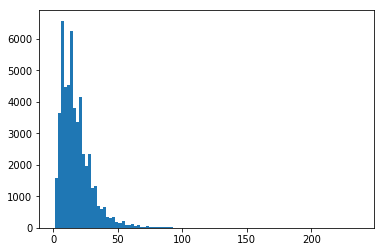

In [8]:
len_arr = [len(x) for x in train_lemmas]
plt.hist(len_arr, bins = 100)
plt.show()

In [9]:
MAX_LEN = 50

In [10]:
train_lemmas = [[x+["PAD"]*MAX_LEN][0][:MAX_LEN] for x in train_lemmas]
val_lemmas = [[x+["PAD"]*MAX_LEN][0][:MAX_LEN] for x in val_lemmas]
test_lemmas = [[x+["PAD"]*MAX_LEN][0][:MAX_LEN] for x in test_lemmas]

In [22]:
train_ids = [[token2id[tok] for tok in sent] for sent in train_lemmas]
val_ids = [[token2id.get(tok, token2id['UNK']) for tok in sent] for sent in val_lemmas]
test_ids = [[token2id.get(tok, token2id['UNK']) for tok in sent] for sent in test_lemmas]

**Кодируем классы**

In [23]:
NUM_CLASSES = 4

classes_list = list(set(y_train))
classes_dict = {c: i for i, c in enumerate(classes_list)}

In [24]:
classes_list

['twitter', 'tolstoy', 'lenta', 'fairytale']

In [41]:
# y_codes_train = [classes_dict[c] for c in y_train]
# y_codes_val = [classes_dict[c] for c in y_val]
# y_codes_test = [classes_dict[c] for c in y_test]

In [25]:
def make_one_hot(words_list):
    oh = np.zeros((len(words_list), NUM_CLASSES))
    for i, word in enumerate(words_list):
        oh[i, classes_dict[word]] = 1
    return oh

y_onehot_train = make_one_hot(y_train)
y_onehot_val = make_one_hot(y_val)
y_onehot_test = make_one_hot(y_test)

**Сначала запустим простой бейзлайн**

In [26]:
vectorizer = TfidfVectorizer()

vectorizer.fit([" ".join([str(y) for y in x]) for x in train_ids])

tfidf_train = vectorizer.transform([" ".join([str(y) for y in x]) for x in train_ids])
tfidf_val = vectorizer.transform([" ".join([str(y) for y in x]) for x in val_ids])

emb_matrix = np.array([model[vocab[int(word)]] if vocab[int(word)] in model else np.zeros((300, )) for word in vectorizer.get_feature_names()])
print(emb_matrix.shape)

X_train = tfidf_train.dot(emb_matrix)
X_val = tfidf_val.dot(emb_matrix)

clf = OneVsRestClassifier(LogisticRegression(random_state=0, C=0.01)).fit(X_train, y_onehot_train)
preds = clf.predict(X_val)
probs = clf.predict_proba(X_val)

for c in classes_list:
    print(c)
    print('f1 = {}'.format(f1_score(y_onehot_val[:, classes_dict[c]], preds[:, classes_dict[c]])))
    print('precision = {}'.format(precision_score(y_onehot_val[:, classes_dict[c]], preds[:, classes_dict[c]])))
    print('recall = {}'.format(recall_score(y_onehot_val[:, classes_dict[c]], preds[:, classes_dict[c]])))
    print()

(51224, 300)
twitter
f1 = 0.7669027688345138
precision = 0.7971887550200804
recall = 0.738833746898263

tolstoy
f1 = 0.75
precision = 0.9127659574468086
recall = 0.6364985163204748

lenta
f1 = 0.9233850776164246
precision = 0.9346173340091232
recall = 0.9124195942602672

fairytale
f1 = 0.8908575478384124
precision = 0.9222303741746148
recall = 0.8615490061686086



**Обучаем полносвязную сетку**

In [55]:
def iterate_minibatches(texts, y, batch_size=64, shuffle=True):
    indices = np.arange(len(texts))
    if shuffle:
        indices = np.random.permutation(indices)
    
    for start in tqdm(range(0, len(indices), batch_size)):
        batch_texts = [texts[i] for i in indices[start : start + batch_size]]
        batch_y = [y[i] for i in indices[start : start + batch_size]]
        yield batch_texts, batch_y

In [28]:
EMB_SIZE = 300

In [29]:
emb_torch = torch.FloatTensor([model[word] if word in model else np.zeros((EMB_SIZE,)) for word in vocab])
print(emb_torch.shape)

torch.Size([51781, 300])


In [59]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(emb_torch, freeze=False)
        self.hidden = nn.Linear(EMB_SIZE, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.55)
        self.out = nn.Linear(64, NUM_CLASSES)

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1)
        x = self.hidden(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.out(x)
        return x

In [60]:
bce_loss = torch.nn.BCEWithLogitsLoss()

BATCH_SIZE = 128
NUM_EPOCHS = 5

nn_model = DenseNet()
nn_model.to(torch.device("cuda"))

opt = torch.optim.Adam(nn_model.parameters(), lr=1e-3)

Epoch 5
Train loss 	0.06374

Val loss 	0.09781
f1 for twitter = 0.8902
f1 for tolstoy = 0.9098
f1 for lenta = 0.9496
f1 for fairytale = 0.9579


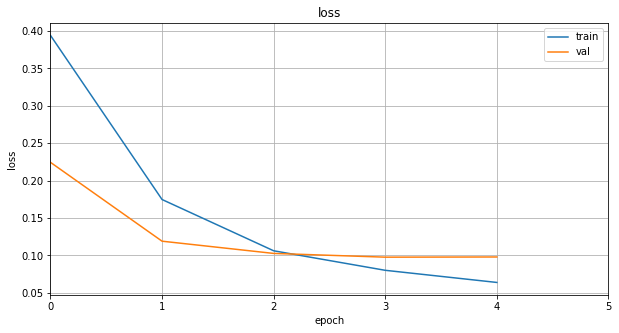

In [61]:
train_losses = []
val_losses = []
epochs = []
sm =  nn.Sigmoid()

for epoch_i in range(NUM_EPOCHS):
      
    nn_model.train(True)
    
    train_loss = train_batches = 0
    
    for batch_x, batch_y in iterate_minibatches(train_ids, y_onehot_train, batch_size=BATCH_SIZE):
        batch_x = torch.tensor(batch_x, dtype=torch.int64).cuda()
        batch_y = torch.tensor(batch_y, dtype=torch.float32).cuda()
        
        prediction = nn_model(batch_x)

        loss = bce_loss(prediction, batch_y)
#         print(loss)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.cpu().data.numpy()
        train_batches += 1
    
    train_losses.append(train_loss / train_batches)
    
    val_loss = val_batches = 0
    nn_model.train(False)
    
    f1_dict = defaultdict(list)
    for batch_x, batch_y in iterate_minibatches(val_ids, y_onehot_val, batch_size=BATCH_SIZE, shuffle=False):
        batch_x = torch.tensor(batch_x, dtype=torch.int64).cuda()
        batch_y = torch.tensor(batch_y, dtype=torch.float32).cuda()
        
        prediction = nn_model(batch_x)

        loss = bce_loss(prediction, batch_y)
        
        val_loss += loss.cpu().data.numpy()
        val_batches += 1
        for i, c in enumerate(classes_list):
            predicted_labels = sm(prediction[:, i])
            predicted_labels = predicted_labels.cpu().detach().numpy()
            predicted_labels[predicted_labels>=0.5] = 1
            predicted_labels[predicted_labels<0.5] = 0
            f1_dict[c].append(f1_score(batch_y[:, i].cpu().detach().numpy(), predicted_labels))
    val_losses.append(val_loss / val_batches)
    
    epochs.append(epoch_i)
    
    clear_output()
    print('Epoch', epoch_i+1)
    print('Train loss \t%.5f' % (train_loss / train_batches))
    print()
    print('Val loss \t%.5f' % (val_loss / val_batches))
    
    for i, c in enumerate(classes_list):
        print("f1 for {} = {:.4f}".format(c, np.mean(f1_dict[c])))
    
    plt.figure(figsize=(10,5))
    plt.title('loss')
    plt.plot(epochs, train_losses, label='train')
    plt.plot(epochs, val_losses, label='val')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.xlim(0, NUM_EPOCHS)
    plt.show()

**Итоговые метрики на валидации**

In [72]:
final_val_labels = defaultdict(list)
for batch_x, batch_y in iterate_minibatches(val_ids, y_onehot_val, batch_size=BATCH_SIZE, shuffle=False):
    batch_x = torch.tensor(batch_x, dtype=torch.int64).cuda()
    prediction = nn_model(batch_x)
    for i, c in enumerate(classes_list):
        predicted_labels = sm(prediction[:, i])
        predicted_labels = predicted_labels.cpu().detach().numpy()
        predicted_labels[predicted_labels>=0.5] = 1
        predicted_labels[predicted_labels<0.5] = 0
        final_val_labels[c] += predicted_labels.tolist()

100%|██████████| 46/46 [00:00<00:00, 497.21it/s]


In [73]:
for c in classes_list:
    print(c)
    print('f1 = {}'.format(f1_score(y_onehot_val[:, classes_dict[c]], final_val_labels[c])))
    print('precision = {}'.format(precision_score(y_onehot_val[:, classes_dict[c]], final_val_labels[c])))
    print('recall = {}'.format(recall_score(y_onehot_val[:, classes_dict[c]], final_val_labels[c])))
    print()

twitter
f1 = 0.8902478274863213
precision = 0.9250836120401338
recall = 0.857940446650124

tolstoy
f1 = 0.90795631825273
precision = 0.9572368421052632
recall = 0.8635014836795252

lenta
f1 = 0.9489846458642892
precision = 0.9499256321269212
recall = 0.9480455220188025

fairytale
f1 = 0.9587061252580866
precision = 0.962681409813407
recall = 0.9547635366689513

